In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import pylab
import numpy as np
import matplotlib as mpl 

X, y = make_moons(n_samples=5000, random_state=42, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=2/5)

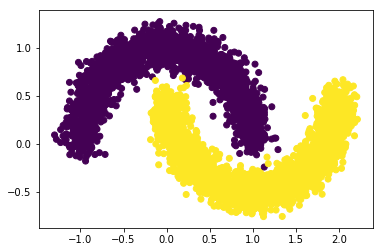

In [3]:
pylab.scatter(X[:,0], X[:,1], c=y)
pylab.show()

In [4]:
# There are only two features in the data X[:,0] and X[:,1]
n_feature = 3
# There are only two classes: 0 (purple) and 1 (yellow)
n_class = 2

In [5]:
def init_weights(n_hidden=100):
    # Initialize weights with Standard Normal random variables
    model = dict(
        W1=np.random.randn(n_feature, n_hidden),
        W2=np.random.randn(n_hidden+1, n_hidden),
        W3=np.random.randn(n_hidden+1, n_class)
    )

    return model

In [6]:
# Defines the softmax function. For two classes, this is equivalent to the logistic regression
def softmax(x):
    return np.exp(x) / np.exp(x).sum()

In [7]:
#define a forward pass
# For a single example $x$
def forward(x, model):
    # Input times first layer matrix 
    x = np.append(x, 1)
    z_1 = x @ model['W1']

    # ReLU activation goes to hidden layer
    h_1 = z_1
    h_1[z_1 < 0] = 0
    
    # intermediate neuron times second layer matrix
    h_1 = np.append(h_1, 1)
    z_2 = h_1 @ model['W2']
    
    # ReLU activation goes to hidden layer
    h_2 = z_2
    h_2[z_2 < 0] = 0

    # intermeiate layer ties third layer matrix
    h_2 = np.append(h_2, 1)
    z_3 = h_2 @ model['W3']
    # Hidden layer values to output through softmax function
    hat_y = softmax(z_3)

    return h_1, h_2, hat_y

In [8]:
def backward(model, xs, hs1, hs2, errs):
    """xs, hs, errs contain all information (input, hidden state, error) of all data in the minibatch"""
    # errs is the gradients of output layer for the minibatch
    dW3 = (hs2.T @ errs)/xs.shape[0]

    # Get gradient of the second hidden layer
    dh2 = errs @ model['W3'].T
    dh2[hs2 <= 0] = 0
    dh2 = dh2[:,:-1]
    
    dW2 = (hs1.T @ dh2)/xs.shape[0]
    
    # Get gradient of the first hidden layer
    dh1 = dh2 @ model['W2'].T
    dh1[hs1 <= 0] = 0 
    dh1 = dh1[:,:-1]
    
    dW1 = (xs.T @ dh1)/xs.shape[0]
    
    return dict(W1=dW1, W2=dW2, W3=dW3)

In [9]:
def get_gradient(model, X_train, y_train):
    xs, hs1, hs2, errs = [], [], [], []

    for x, cls_idx in zip(X_train, y_train):
        h1, h2, y_pred = forward(x, model)

        # Create one-hot coding of true label
        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.

        # Compute the gradient of output layer
        err = y_true - y_pred

        # Accumulate the informations of the examples
        # x: input
        # h: hidden state
        # err: gradient of output layer
        x = np.append(x,1)
        xs.append(x)
        hs1.append(h1)
        hs2.append(h2)
        errs.append(err)

    # Backprop using the informations we get from the current minibatch
    return backward(model, np.array(xs), np.array(hs1), np.array(hs2), np.array(errs))

In [10]:
def gradient_step(model, X_train, y_train, learning_rate = 1e-1):
    grad = get_gradient(model, X_train, y_train)
    model = model.copy()

    # Update every parameters in our networks (W1 and W2) using their gradients
    for layer in grad:
        # Careful, learning rate should depend on mini-batch size
        model[layer] += learning_rate * grad[layer]

    return model

In [11]:
def gradient_descent(model, X_train, y_train, no_iter=10):

    minibatch_size = 50
    
    for iter in range(no_iter):
        print('Iteration (epoch) {}'.format(iter))

        ## MINI-BATCH: Shuffles the training data to sample without replacement
        indices = list(range(0,X_train.shape[0]))
        np.random.shuffle(indices)
        X_train = X_train[indices,:]
        y_train = y_train[indices]

        for i in range(0, X_train.shape[0], minibatch_size):
            # Get pair of (X, y) of the current mini-batch
            X_train_mini = X_train[i:i + minibatch_size]
            y_train_mini = y_train[i:i + minibatch_size]

            model = gradient_step(model, X_train_mini, y_train_mini, learning_rate = 1e-1)

    return model

In [12]:
no_iter = 10

# Reset model
model = init_weights()

zero_one_loss = []
# Train the model
training_data_size=[100, 500, 1000, 2000, 3000]
for x in training_data_size:
    model = gradient_descent(model, X_train[0:x,:], y_train[0:x], no_iter=no_iter)

    y_pred = np.zeros_like(y_test)
    accuracy = 0
    
    for i, x in enumerate(X_test):
        # Predict the distribution of label
        _, _, prob = forward(x, model)
        # Get label by picking the most probable one
        y = np.argmax(prob)
        y_pred[i] = y

        # Accuracy of predictions with the true labels and take the percentage
        # Because our dataset is balanced, measuring just the accuracy is OK
        # accuracy = (y_pred == y_test).sum() / y_test.size
    zero_one_loss = np.append(zero_one_loss, (y_pred != y_test).sum()/y_test.size)

print('zero_one_loss:{}'.format(zero_one_loss) )
#print('Accuracy after {} iterations: {}'.format(no_iter,accuracy))

Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9
Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9
Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9
Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9
Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9


In [24]:
no_iter = 10

# Reset model
model = init_weights()

zero_one_loss_1 = []
# Train the model
training_data_size=[100, 500, 1000, 2000, 3000]
for x in training_data_size:
    X_train = X_train[0:x,:]
    y_train = y_train[0:x]
    #model = gradient_descent(model, X_train[0:x,:], y_train[0:x], no_iter=no_iter)
    model = gradient_descent(model, X_train, y_train, no_iter=no_iter)
    y_pred = np.zeros_like(y_train)
    accuracy = 0
    
    for i, x in enumerate(X_train):
        # Predict the distribution of label
        _, _, prob = forward(x, model)
        # Get label by picking the most probable one
        y = np.argmax(prob)
        y_pred[i] = y

        # Accuracy of predictions with the true labels and take the percentage
        # Because our dataset is balanced, measuring just the accuracy is OK
        # accuracy = (y_pred == y_test).sum() / y_test.size
    zero_one_loss_1 = np.append(zero_one_loss_1, (y_pred != y_train).sum()/y_train.size)

print('zero_one_loss:{}'.format(zero_one_loss_1) )
#print('Accuracy after {} iterations: {}'.format(no_iter,accuracy))

Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9
Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9
Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9
Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9
Iteration (epoch) 0
Iteration (epoch) 1
Iteration (epoch) 2
Iteration (epoch) 3
Iteration (epoch) 4
Iteration (epoch) 5
Iteration (epoch) 6
Iteration (epoch) 7
Iteration (epoch) 8
Iteration (epoch) 9


C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Joey\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Joey\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


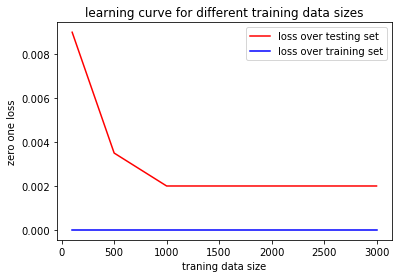

In [25]:
from numpy import *
from matplotlib.pyplot import *
t=[100, 500, 1000, 2000, 3000]
y1 = zero_one_loss
y2 = zero_one_loss_1
plot(t, y1, 'r-')
hold('on')
plot(t, y2, 'b-')
xlabel('traning data size')
ylabel('zero one loss')
legend(['loss over testing set', 'loss over training set'])
title('learning curve for different training data sizes')
show()

In [ ]:
pylab.scatter(X_test[:,0], X_test[:,1], c=y_pred)
pylab.show()

In [ ]:
no_iter = 100
no_runs = 20

accuracies = np.zeros(no_runs)

for run in range(no_runs):
    print("Run {}".format(run))
    # Reset model
    model = init_weights()

    # Train the model
    model = gradient_descent(model, X_train, y_train, no_iter=no_iter)

    y_pred = np.zeros_like(y_test)
    
    for i, x in enumerate(X_test):
        # Predict the distribution of label
        _, _, prob = forward(x, model)
        # Get label by picking the most probable one
        y = np.argmax(prob)
        y_pred[i] = y

        # Accuracy of predictions with the true labels and take the percentage
        # Because our dataset is balanced, measuring just the accuracy is OK
        accuracies[run]= (y_pred == y_test).sum() / y_test.size


print('Mean accuracy over test data: {}, std: {}'.format(accuracies.mean(), accuracies.std()))

In [ ]:
print(accuracies)

In [ ]:
# plot the boxplot over accuracies of 20 runs
## agg backend is used to create plot as a .png file
mpl.use('agg')
import matplotlib.pyplot as plt 

original_accuracies=[0.92,0.92,0.92,0.91,0.92,0.9,0.92,0.83,0.92,0.92,0.92,0.92,0.92,0.92,0.92,0.91,0.92,0.9,0.92,0.85]

data = [accuracies,original_accuracies]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data)
plt.xticks([1, 2], ['a', 'b'])

# Save the figure
fig.savefig('boxplot2.png')


In [ ]:
from scipy import stats
print(original_accuracies)
print(accuracies)
original_accuracies = np.asarray(original_accuracies)
new_accuracies = np.asarray(accuracies)
print(original_accuracies.mean())
print(new_accuracies.mean())
difference = original_accuracies.mean() - new_accuracies.mean()
print(difference)

0.0805/0.230422980625
stats.ttest_ind(original_accuracies, new_accuracies)